In [1]:
import sys
sys.path.append('..')
import argparse
import seaborn as sns
import datasets
import numpy as np
import torch
import transformers
from tqdm.notebook import tqdm, trange
from data import get_data, TASKS
import matplotlib.pyplot as plt

args_dict = {
    'max_dset_size': 10_000,
    'template_num_task_phrasing': 0,
    'n_shots': 1,
    'max_digit': 10,
}
args = argparse.Namespace(**args_dict)

task_names = TASKS.keys()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_name = 'gpt2-medium'
model_name = 'EleutherAI/gpt-j-6B' # 'EleutherAI/gpt-neox-20b'
batch_size = 1

# load stuff
model = transformers.AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=False)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, output_hidden_states=False)

In [2]:
def test_model_on_task_with_prefix(dset: datasets.Dataset, model: transformers.PreTrainedModel,
                                   tokenizer: transformers.PreTrainedTokenizer,
                                   prefix: str = '', batch_size: int = 32) -> float:
    """Tests a given language model on a dataset and returns {zero,few}-shot loss. 

    Args:
        dset (datasets.Dataset): dataset of examples 
        model (transformers.PreTrainedModel): language model for testing
        tokenizer (transformers.PreTrainedModel): tokenizer to accompany `model`
        prefix (str): Prefix that will be prepended to each example
        batch_size (int): batch size for evaluation

    Returns:
        loss (float): language modeling loss on examples in dataset
    """
    np.random.seed(42)
    torch.manual_seed(42)

    model.eval()
    model.to(device)

    tokenizer.pad_token = tokenizer.eos_token

    dataloader = torch.utils.data.DataLoader(
        dset, batch_size=batch_size, shuffle=False, drop_last=False)
    total_loss = 0.0
    total_n = 0
    total_n_correct = 0.0

    # Compute loss only over possible answers to make task easier
    possible_answer_ids = []
    for batch in dataloader:
        y_text = [answer for answer in batch['output']]
        y_tokenized = tokenizer(y_text, return_tensors='pt', padding='longest')
        # only test on the single next token
        true_next_token_ids = y_tokenized['input_ids'][:, 0]
        possible_answer_ids.extend(true_next_token_ids.tolist())

    assert len(
        possible_answer_ids) > 0, "need multiple answers for multiple choice"

    possible_answer_ids = torch.tensor(possible_answer_ids)
    vocab_size = len(tokenizer.vocab)
    possible_answer_mask = (
        torch.arange(start=0, end=vocab_size)[:, None]
        ==
        possible_answer_ids[None, :]
    ).any(dim=1).to(device)

    for idx, batch in enumerate(dataloader):
        x_text = [(prefix + prompt) for prompt in batch['input']]
        y_text = [answer for answer in batch['output']]
        if idx == 0:
            print(list(zip(x_text[:2], y_text[:2])))

        x_tokenized = tokenizer(
            x_text, return_tensors='pt', padding='longest').to(device)
        y_tokenized = tokenizer(
            y_text, return_tensors='pt', padding='longest').to(device)

        # only test on the single next token
        true_next_token_ids = y_tokenized['input_ids'][:, 0]

        with torch.no_grad():
            all_token_logits = model(**x_tokenized)['logits']
            pred_next_token_logits = all_token_logits[:, -1, :]
            # import pdb; pdb.set_trace()
            pred_next_token_logits = torch.where(
                possible_answer_mask, pred_next_token_logits, torch.tensor(
                    float('-inf')).to(device)
            )
            loss = torch.nn.functional.cross_entropy(
                input=pred_next_token_logits, target=true_next_token_ids, reduction='sum')
        total_loss += loss.item()
        total_n += len(x_text)
        total_n_correct += (pred_next_token_logits.argmax(dim=-1)
                            == true_next_token_ids.flatten()).int().sum().item()

    return (total_loss / total_n), (total_n_correct * 100.0 / total_n)


Do a simple test

In [3]:
task_name = 'square_one'
prefix = f'asldjfo the following numbers. '
dset, check_answer_func, description = get_data(args=args, task_name=task_name)
test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=prefix, batch_size=batch_size)

10 max_digit 10 dset_size 10000 10
[('asldjfo the following numbers. Given the input x is 9, the output f(x) is', ' 81.\n\n')]


(2.301147586107254, 20.0)

Loop and check the tasks

In [4]:
task_information = {}
task_descriptions = []
task_names = ['add_two', 'divide_two', 'max_two', 'subtract_two', 'first_two', 'multiply_two']
# task_names = ['add_two', 'multiply_two', 'divide_two', 'subtract_two', 'max_two', 'first_two', 'SUFFIXES', 'square_one', 'exp_one', 'prime_one', 'double_one', 'fibonacci_one']
# task_names = list(set(TASKS.keys()) - {'SUFFIXES'})

for name in task_names:
    # print(name)
    dset, check_answer_func, description = get_data(args=args, task_name=name)
    task_descriptions.append(description)
    
task_descriptions

100 max_digit 10 dset_size 10000 100
100 max_digit 10 dset_size 10000 100
100 max_digit 10 dset_size 10000 100
100 max_digit 10 dset_size 10000 100
100 max_digit 10 dset_size 10000 100
100 max_digit 10 dset_size 10000 100


['Return the sum of the inputs.',
 'Return the quotient of the inputs.',
 'Return the maximum of the inputs.',
 'Return the difference of the inputs.',
 'Return the first of the inputs.',
 'Return the product of the inputs.']

# actually compute losses / accs

In [5]:
# TODO incorporate check_answer_func... And use huggingface decoding for that?
losses = np.zeros((len(task_names), len(task_descriptions)))
accuracies = np.zeros((len(task_names), len(task_descriptions)))

for i in trange(len(task_names), colour='red'):
    name = task_names[i]
    for j in range(len(task_descriptions)):
        description = task_descriptions[j]
        #
        dset, check_answer_func, __this_task_description = get_data(args=args, task_name=name)
        loss, acc = test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=f'{description} ')
        losses[i][j] += loss
        accuracies[i][j] += acc
        # print(f'Task: {name} \t Prefix: {description} \t Loss: {loss:.2f}')

  0%|          | 0/6 [00:00<?, ?it/s]

100 max_digit 10 dset_size 10000 100
[('Return the sum of the inputs. Given the input numbers 7 and 8, the answer is', ' 15.\n\n'), ('Return the sum of the inputs. Given the input numbers 6 and 8, the answer is', ' 14.\n\n')]
100 max_digit 10 dset_size 10000 100
[('Return the quotient of the inputs. Given the input numbers 8 and 3, the answer is', ' 11.\n\n'), ('Return the quotient of the inputs. Given the input numbers 5 and 3, the answer is', ' 8.\n\n')]
100 max_digit 10 dset_size 10000 100
[('Return the maximum of the inputs. Given the input numbers 8 and 3, the answer is', ' 11.\n\n'), ('Return the maximum of the inputs. Given the input numbers 5 and 3, the answer is', ' 8.\n\n')]
100 max_digit 10 dset_size 10000 100
[('Return the difference of the inputs. Given the input numbers 8 and 3, the answer is', ' 11.\n\n'), ('Return the difference of the inputs. Given the input numbers 5 and 3, the answer is', ' 8.\n\n')]
100 max_digit 10 dset_size 10000 100
[('Return the first of the inp

# visualize

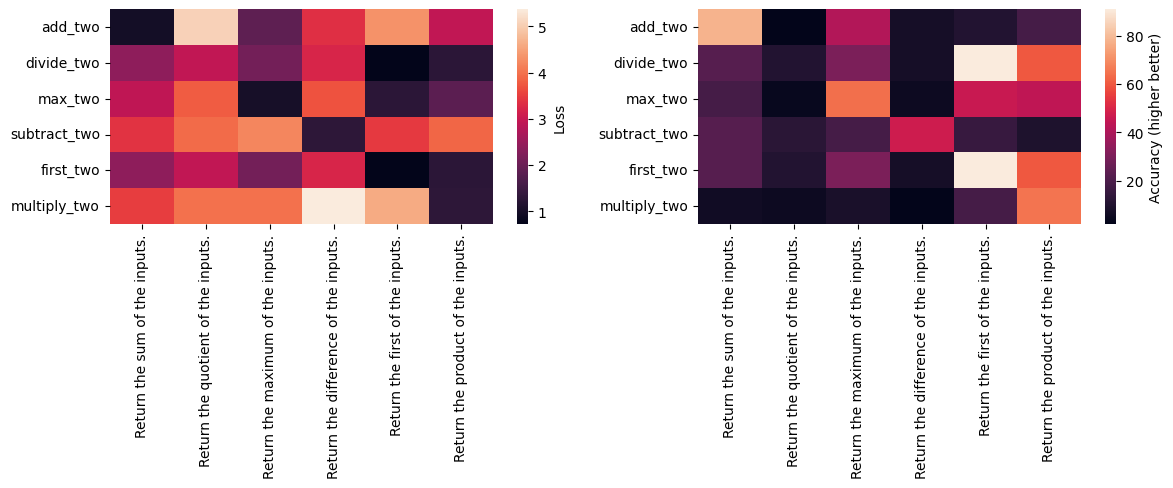

In [12]:
# sns.set()
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(losses, yticklabels=task_names,
            xticklabels=task_descriptions, cbar_kws={'label': 'Loss'})
# sns.heatmap(torch.tensor(losses).softmax(dim=1), yticklabels=task_names,
            # xticklabels=task_descriptions, cbar_kws={'label': 'Loss, normalized (lower better)'})

plt.subplot(122)
sns.heatmap(torch.tensor(accuracies), yticklabels=task_names,
            xticklabels=task_descriptions, cbar_kws={'label': 'Accuracy (higher better)'})
plt.tight_layout()


Note on division: division task looks like “{prefix} Given the numbers 9 and 3, the answer is 9/3” and since it’s just next token prediction the model just needs to predict the 9, not the full 9/3. So the fact that “return the first of the inputs” is the best prompt makes a lot of sense

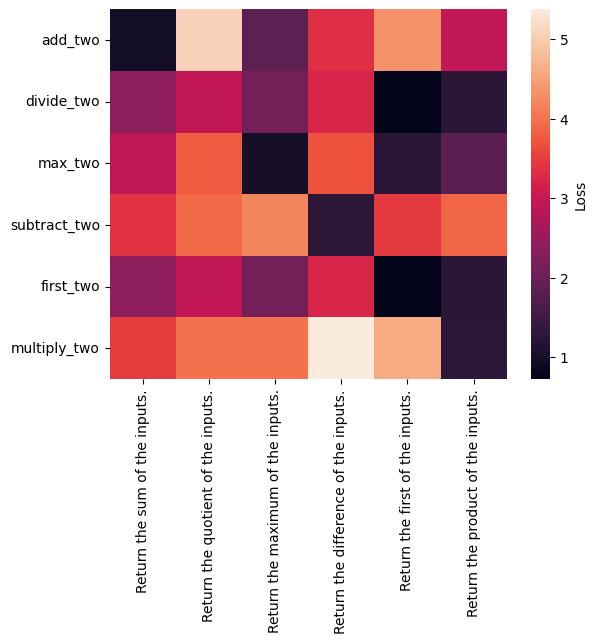

In [18]:
sns.heatmap(losses, yticklabels=task_names,
            xticklabels=task_descriptions, cbar_kws={'label': 'Loss'})
plt.savefig(f'figs/heatmap_{model_name.replace("/", "___")}')